In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.single_transformations import single_direction_transformation
from project_ssms.feature_funcs import feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import k_step_prediction_for_grid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

import joblib

# data

In [14]:
trajs_all = joblib.load("trajs_all")
trajs = trajs_all[36000*0:36000*2]
f_trajs = filter_traj_by_speed(trajs, q1=0.9, q2=0.9)

In [15]:
arena_xmin = 10
arena_xmax = 320
arena_ymin = -10
arena_ymax = 390

In [16]:
# make 3 by 3 grid world
x_grid_gap = (arena_xmax - arena_xmin) / 3
y_grid_gap = (arena_ymax - arena_ymin) / 3

x_grids = [arena_xmin + i * x_grid_gap for i in range(4)]
y_grids = [arena_ymin + i * y_grid_gap for i in range(4)]

In [17]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [18]:
bounds

array([[ 10, 320],
       [-10, 390],
       [ 10, 320],
       [-10, 390]])

In [19]:
CORNERS = torch.tensor([[10, -10], [10, 390], [320, -10], [320, 390]], dtype=torch.float64)

In [20]:
def plot_grid():
    plt.scatter([10,10,320,320],[-10,390,-10,390])
    for j in range(4):
        plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

    for i in range(4):
        plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

        
def ax_grid(ax):
    ax.scatter([10,10,320,320],[-10,390,-10,390])
    for j in range(4):
        ax.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

    for i in range(4):
        ax.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

In [21]:
def plot_realdata_quiver(realdata, scale=0.3, alpha=0.8, xlim=None, ylim=None):
    assert isinstance(realdata, np.ndarray), "please input ndarray"
    start = realdata[:-1]
    end = realdata[1:]
    dXY = end - start
    
    plt.subplot(1,2,1)
    plt.quiver(start[:, 0], start[:, 1], dXY[:, 0], dXY[:, 1],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
    plot_grid()
    plt.title("virgin")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.subplot(1,2,2)
    plt.quiver(start[:, 2], start[:, 3], dXY[:, 0], dXY[:, 1],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
    plot_grid()
    plt.title("mother")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

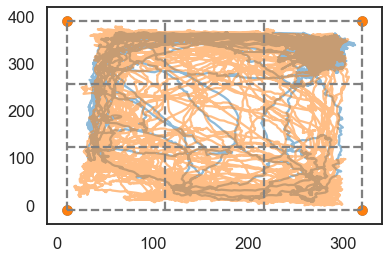

In [22]:
plot_2_mice(trajs, alpha=0.5)
plt.scatter([10,10,320,320],[-10,390,-10,390])
plot_grid()

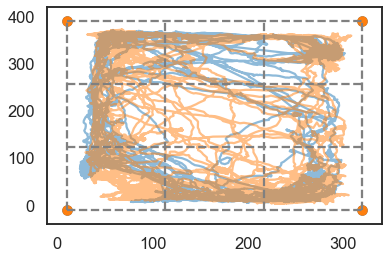

In [30]:
plot_2_mice(trajs_all[36000*15:36000*18], alpha=0.5)
plt.scatter([10,10,320,320],[-10,390,-10,390])
plot_grid()

In [27]:
trajs.shape

(72000, 4)

In [35]:
def downsample(traj, n):
    # data : (T, D)
    T, _ = traj.shape
    T_over_n = int(T/n)
    idx = n*np.arange(T_over_n)
    return traj[idx]
    

In [37]:
trajs.shape

(72000, 4)

In [58]:
down_sampled_trajs = downsample(trajs, 2)
down_sampled_trajs_3 = downsample(trajs, 3)
down_sampled_trajs_4 = downsample(trajs, 4)

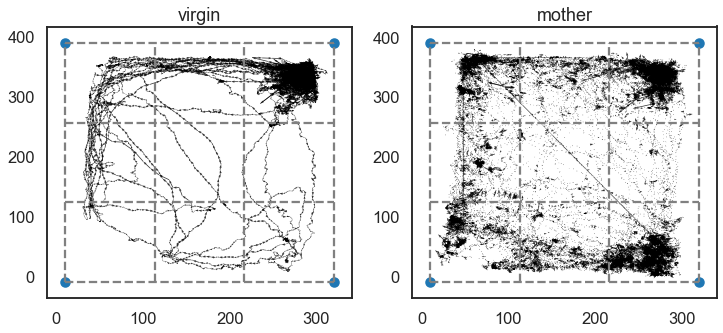

In [62]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(trajs, scale=1)

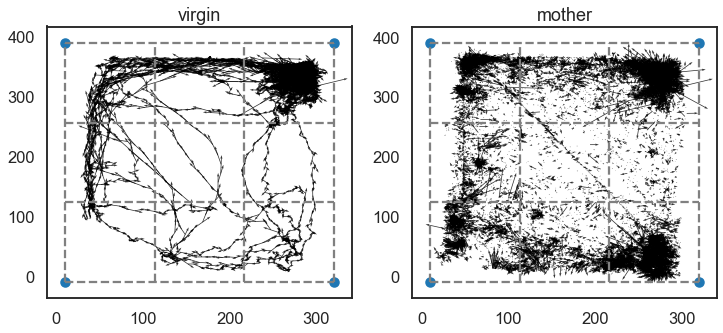

In [48]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(down_sampled_trajs, scale=0.5)

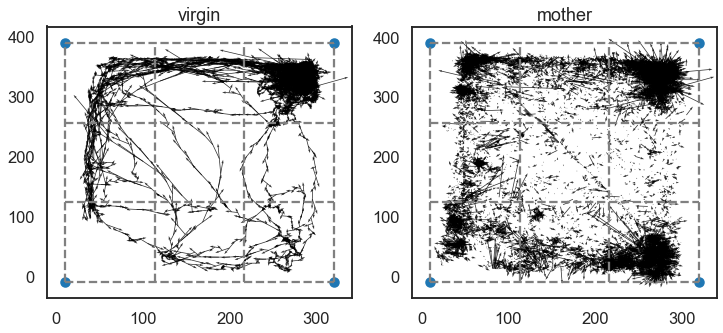

In [51]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(down_sampled_trajs_3, scale=0.5)

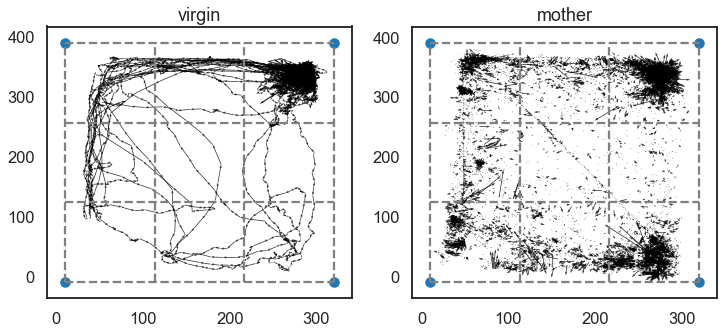

In [61]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(down_sampled_trajs_4, scale=1)

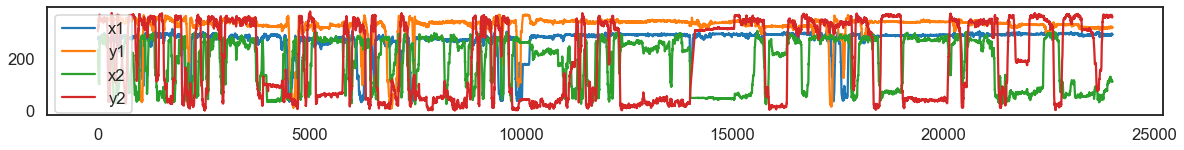

In [53]:
plt.figure(figsize=(20,2))
plot_4_traces(down_sampled_trajs_3)

/Users/leah/miniconda2/envs/ptc/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/leah/miniconda2/envs/ptc/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


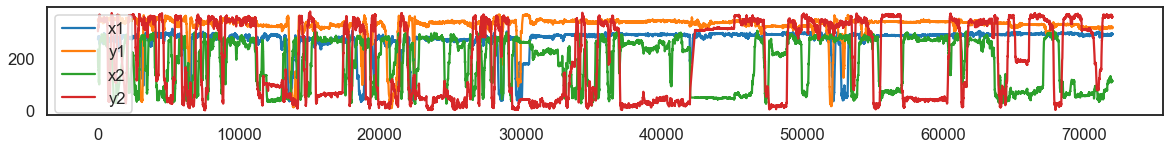

In [55]:
plt.figure(figsize=(20,2))
plot_4_traces(trajs)

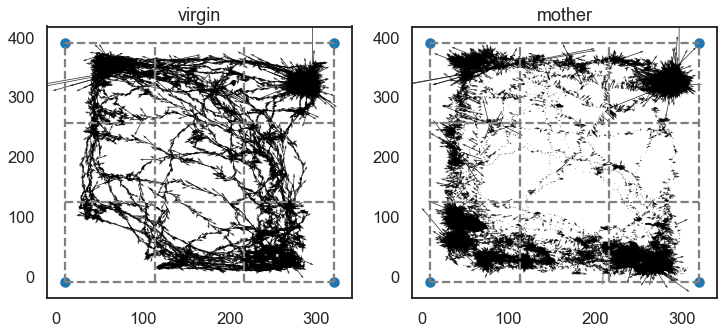

In [49]:
plt.figure(figsize=(12,5))
plot_realdata_quiver(trajs_all[36000*5:36000*8])

In [10]:
data = torch.tensor(trajs, dtype=torch.float64)

In [22]:
np.min(trajs_all, axis=0)

array([20.68859416,  4.78160906, 10.99923861, -1.43330193])

In [24]:
np.max(trajs_all, axis=0)

array([314.26579452, 374.9678278 , 317.12118077, 379.03557754])

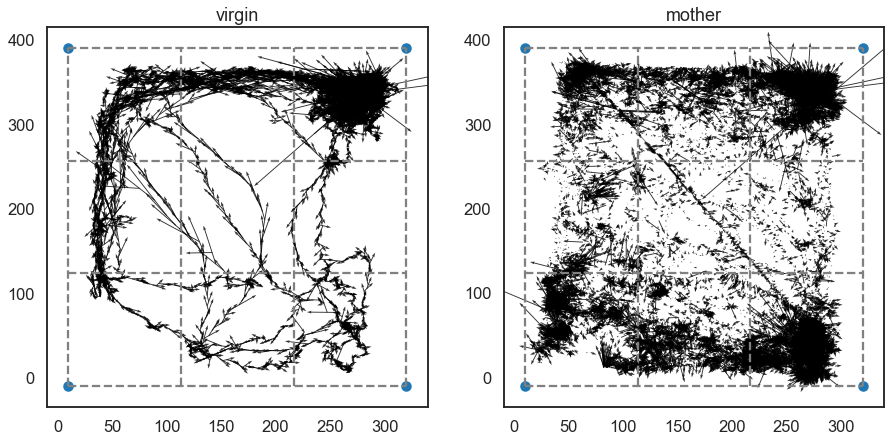

In [13]:
plt.figure(figsize=(15,7))
plot_realdata_quiver(data.numpy())

# model

In [73]:
def f_corner_vec_func(s):
    return feature_direction_vec(s, CORNERS)

In [14]:
torch.manual_seed(0)
np.random.seed(0)

D = 4
K = 4
M = 0

Df = 4

#f_corner_vec_func = lambda s: feature_direction_vec(s, CORNERS)

bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])


tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, single_transformation="direction",
                          Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=10)

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

# model
model = HMM(K=K, D=D, M=M, observation=obs)


In [15]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [16]:
log_prob = model.log_likelihood(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

In [17]:
log_prob

tensor(-1994921.2505, dtype=torch.float64, grad_fn=<AddBackward0>)

In [19]:
params = joblib.load("model_k4")

In [20]:
model.params = params

In [21]:
model.log_likelihood(data)

tensor(-227688.1493, dtype=torch.float64, grad_fn=<AddBackward0>)

In [15]:
##################### training ############################

num_iters = 2000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 263375.87: 100%|██████████| 2000/2000 [24:06<00:00,  1.61it/s]


In [19]:
##################### training ############################

num_iters = 2000
losses, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 232752.12: 100%|██████████| 2000/2000 [28:18<00:00,  1.57it/s]


In [21]:
##################### training ############################

num_iters = 2000
losses_2, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 228575.31: 100%|██████████| 2000/2000 [20:34<00:00,  1.30it/s]


In [79]:
##################### training ############################

num_iters = 2000
losses_3, _ = model.fit(data, optimizer=opt, num_iters=num_iters, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 1990 loss 227698.30: 100%|██████████| 2000/2000 [28:47<00:00,  1.22it/s]


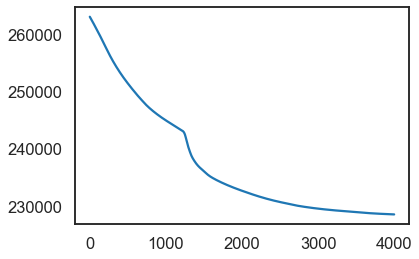

In [22]:
plt.plot(losses + losses_2)

In [22]:
print("inferiring most likely states...")
z = model.most_likely_states(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

inferiring most likely states...


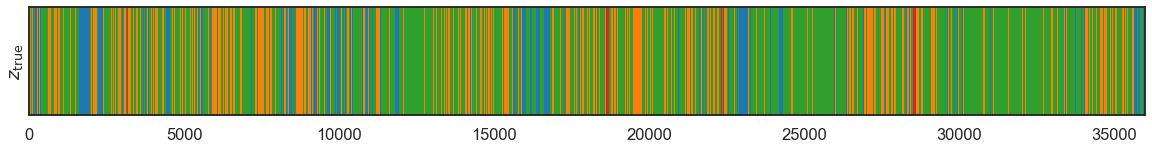

In [23]:
plot_z(z)

In [24]:
print("0 step prediction")
x_predict = k_step_prediction_for_grid_model(model, z, data, memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

0 step prediction


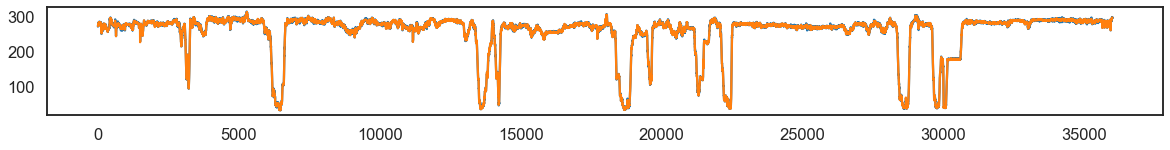

In [25]:
plt.figure(figsize=(20,2))
plt.plot(x_predict[:,0])
plt.plot(data[:,0].numpy())

In [26]:
np.mean(np.abs(x_predict-data.numpy()), axis=0)

array([1.1725065 , 1.18148457, 1.75841976, 1.72570903])

# sample

In [45]:
sample_z, sample_x = model.sample(36000)

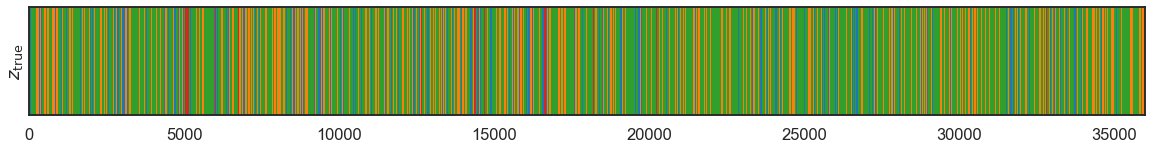

In [46]:
plot_z(sample_z)

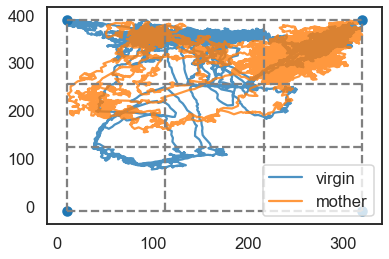

In [47]:
plot_2_mice(sample_x)
plt.legend()
plot_grid()

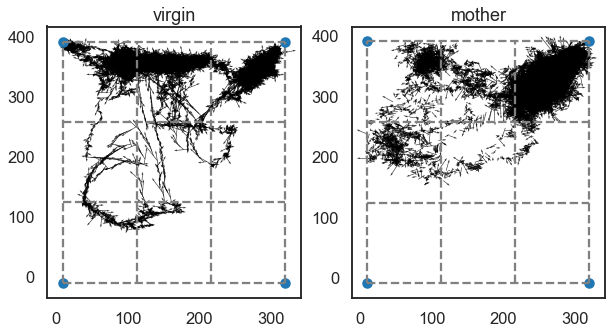

In [50]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x)

In [29]:
center_z = torch.tensor([0], dtype=torch.int)
center_x = torch.tensor([[150, 190, 200, 200]], dtype=torch.float64)

In [30]:
sample_z_center, sample_x_center = model.sample(10000, prefix=(center_z, center_x))

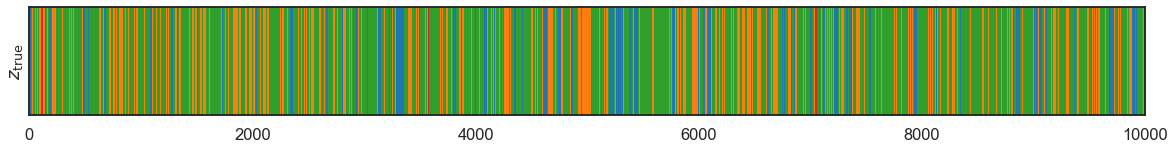

In [31]:
plot_z(sample_z_center)

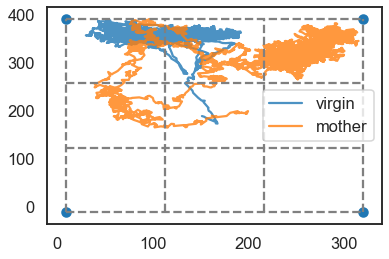

In [36]:
plot_2_mice(sample_x_center)
plt.legend()
plot_grid()

In [33]:
sample_z_center2, sample_x_center2 = model.sample(10000, prefix=(center_z, center_x))

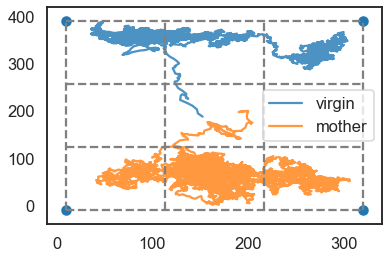

In [37]:
plot_2_mice(sample_x_center2)
plt.legend()
plot_grid()

In [35]:
sample_z_center3, sample_x_center3 = model.sample(36000, prefix=(center_z, center_x))

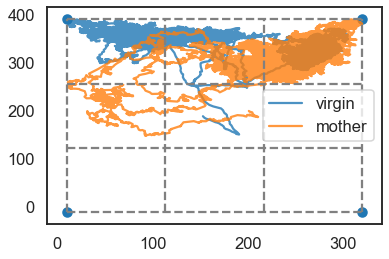

In [38]:
plot_2_mice(sample_x_center3)
plt.legend()
plot_grid()

In [39]:
sample_z_center4, sample_x_center4 = model.sample(36000, prefix=(center_z, center_x))

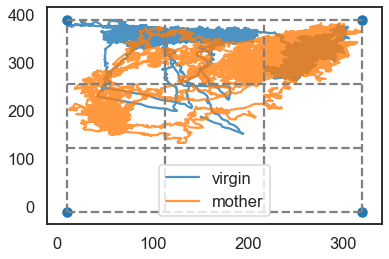

In [40]:
plot_2_mice(sample_x_center4)
plt.legend()
plot_grid()

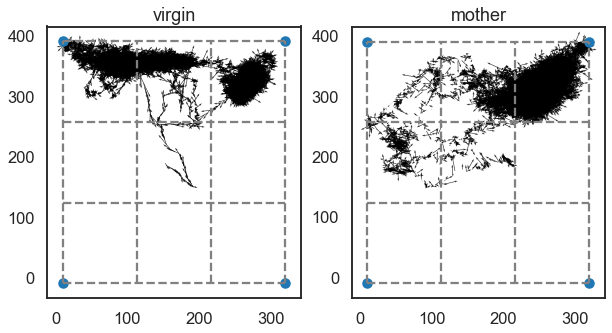

In [53]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center3)

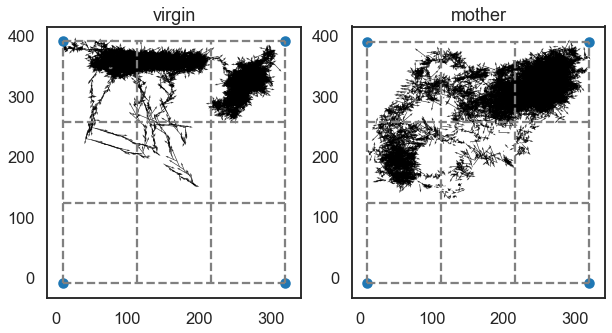

In [52]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center4)

In [27]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7438, 0.7755, 0.4080, 0.3120],
        [1.9807, 2.0146, 3.2856, 3.3133],
        [0.7220, 0.6986, 1.0906, 1.0200],
        [1.0762, 1.2390, 1.9742, 1.7643]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

# dynamics

In [32]:
plot_to_grid = {1:2, 2:5, 3: 8, 4: 1, 5: 4, 6: 7, 7:0, 8:3, 9:6}

In [33]:
def plot_weights(weights, Df):
    plt.figure(figsize=(16, 12))
    
    gap = 0.8 / (K-1)
    
    for plot_idx, grid_idx in plot_to_grid.items():
        plt.subplot(3,3,plot_idx)
        plt.title("Grid {}".format(grid_idx))
        for k in range(K):
            plt.bar(np.arange(Df) - 0.4 + k*gap, weights[grid_idx][k], width=.2, label='k={}'.format(k))
        plt.plot([0, Df], [0, 0], '-k')
        plt.ylim(0, 10)
        plt.xticks(np.arange(0,Df,1), ["lower L", "upper L", "lower R", "upper R"])
        plt.grid()
        plt.legend()

    plt.tight_layout()

In [34]:
weights_a = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_a])
weights_b = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_b])

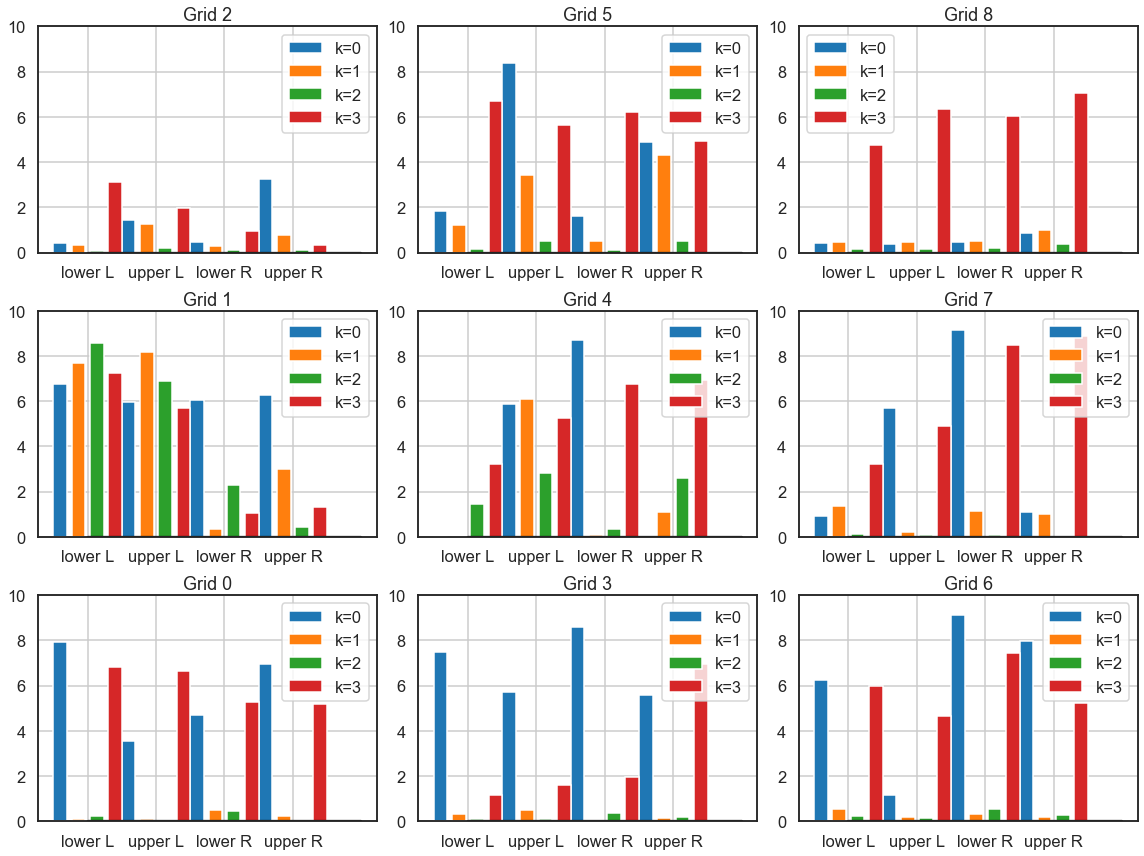

In [35]:
plot_weights(weights_a, Df=4)

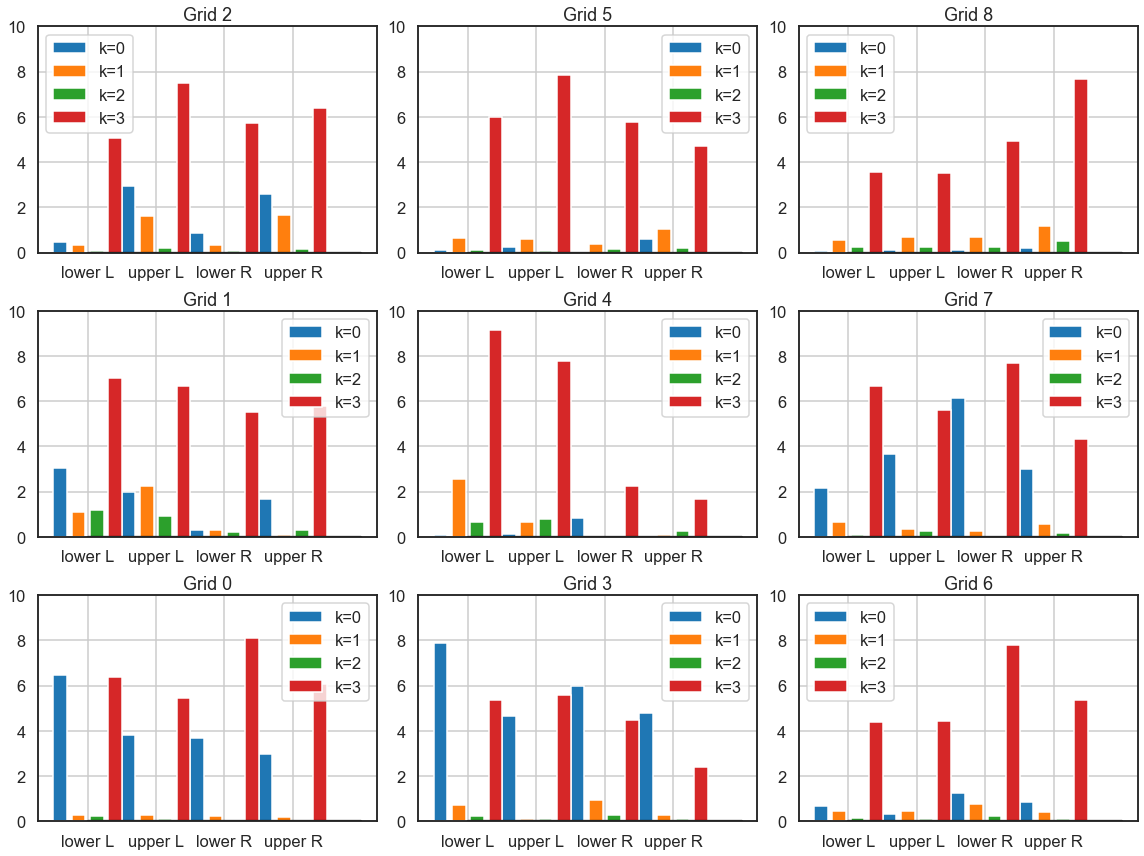

In [36]:
plot_weights(weights_b, Df=4)

In [37]:
CORNERS

tensor([[ 10., -10.],
        [ 10., 390.],
        [320., -10.],
        [320., 390.]], dtype=torch.float64)

In [38]:
grid_centers = np.array([[1/2*(x_grids[i] + x_grids[i+1]), 1/2*(y_grids[j] + y_grids[j+1])] for i in range(3) for j in range(3)])

In [39]:
out = f_corner_vec_func(torch.tensor(grid_centers, dtype=torch.float64))
corner_vecs = out.numpy()
# (G, 1, Df, d) * (G, K, Df, 1) --> (G, K, Df, d) 
weighted_corner_vecs_a = corner_vecs[:, None] * weights_a[..., None]
weighted_corner_vecs_b = corner_vecs[:, None] * weights_b[..., None]

In [40]:
out = f_corner_vec_func(torch.tensor(grid_centers[3], dtype=torch.float64))

In [41]:
# (Df, 2) * (K, Df, 1) = (K, Df, 2)
w_out = out.numpy() * weights_b[3][..., None]

In [42]:
out[0][0]

tensor([-0.9186, -0.3951], dtype=torch.float64)

In [43]:
w_out[0][0]

array([-7.2569583 , -3.12127239])

In [44]:
(CORNERS[0].numpy() - grid_centers[3] ) / w_out[0][0]

array([21.35881089, 21.35881089])

In [45]:
G = 9

In [46]:
def plot_percentage(k, percentage):
    if percentage is None:
        return
    
    texts = ["{0:.2f}%".format(percentage[g][k]*100) for g in range(G)]
    
    for c, text in zip(grid_centers, texts):
        plt.text(c[0]+20, c[1]+40, text, fontsize=12, color='k')
    

In [54]:
def plot_dynamics(weighted_corner_vecs, animal, scale=0.1, percentage=None):
    result_corner_vecs = np.sum(weighted_corner_vecs, axis=2)
    
    """
    plt.figure(figsize=(10,10))
    """
    plt.figure(figsize=(20, 5))
    
    def plot_dynamics_k(k):
        plot_grid()
        
        plot_percentage(k, percentage=percentage)
        
        for df in range(Df):
            plt.quiver(grid_centers[:,0], grid_centers[:,1], weighted_corner_vecs[:,k,df,0], weighted_corner_vecs[:,k,df,1], 
                       units='xy', scale=scale, width=2, alpha=0.5)

        plt.quiver(grid_centers[:,0], grid_centers[:,1], result_corner_vecs[:,k,0], result_corner_vecs[:,k,1],
                      units='xy', scale=scale, width=2, color='red',alpha=0.5)
        plt.title("K={}, ".format(k) + animal, fontsize=20)
    """
    plt.subplot(2,2,1)
    plot_dynamics_k(0)
    plt.subplot(2,2,2)
    plot_dynamics_k(1)
    plt.subplot(2,2,3)
    plot_dynamics_k(2)
    plt.subplot(2,2,4)
    plot_dynamics_k(3)
    """
    plt.subplot(1,4,1)
    plot_dynamics_k(0)
    plt.subplot(1,4,2)
    plot_dynamics_k(1)
    plt.subplot(1,4,3)
    plot_dynamics_k(2)
    plt.subplot(1,4,4)
    plot_dynamics_k(3)
    
    plt.tight_layout()

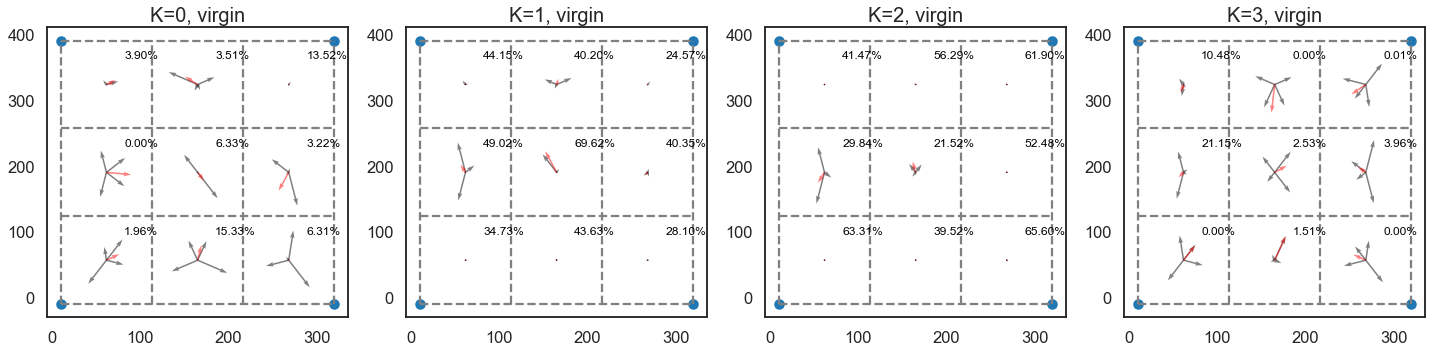

In [142]:
plot_dynamics(weighted_corner_vecs_a, "virgin", scale=0.2, percentage=grid_z_a_percentage)

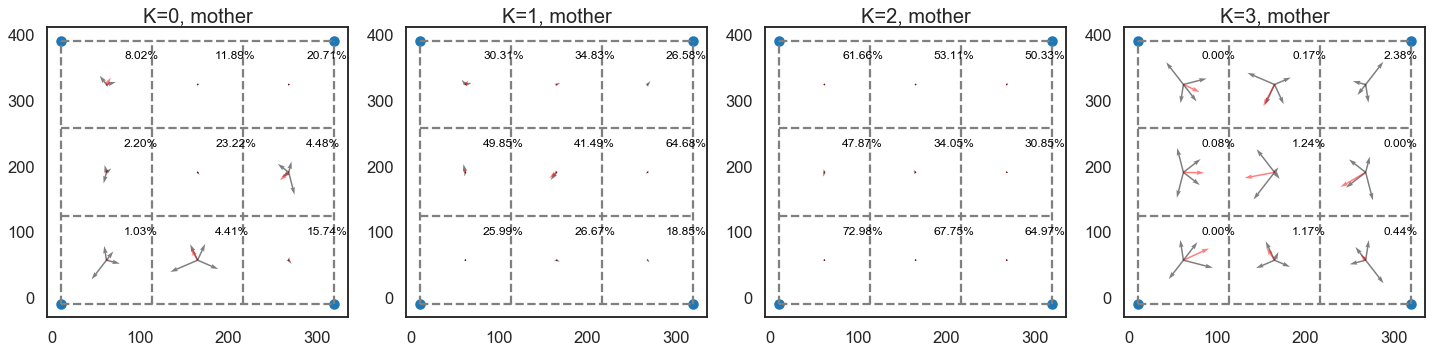

In [153]:
plot_dynamics(weighted_corner_vecs_b, "mother", scale=0.2, percentage=grid_z_b_percentage)

In [159]:
grid_centers.shape

(9, 2)

In [163]:
CORNERS

tensor([[ 10., -10.],
        [ 10., 390.],
        [320., -10.],
        [320., 390.]], dtype=torch.float64)

In [55]:
def plot_quiver(XYs, dXYs, mouse, scale=1, alpha=1):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3

    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    
    for k in range(K):
        axs[k].quiver(XYs[:, i], XYs[:, j], dXYs[:, k, i], dXYs[:, k, j],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
        axs[k].set_title('K={} '.format(k) + mouse)

    plt.tight_layout()


In [56]:
# quiver
XX, YY = np.meshgrid(np.linspace(20, 310, 30), 
                     np.linspace(0, 380, 30))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [57]:
XY_grids = np.concatenate((XY, XY), axis=1)

XY_next = tran.transform(torch.tensor(XY_grids, dtype=torch.float64))
dXY = XY_next.detach().numpy() - XY_grids[:, None]


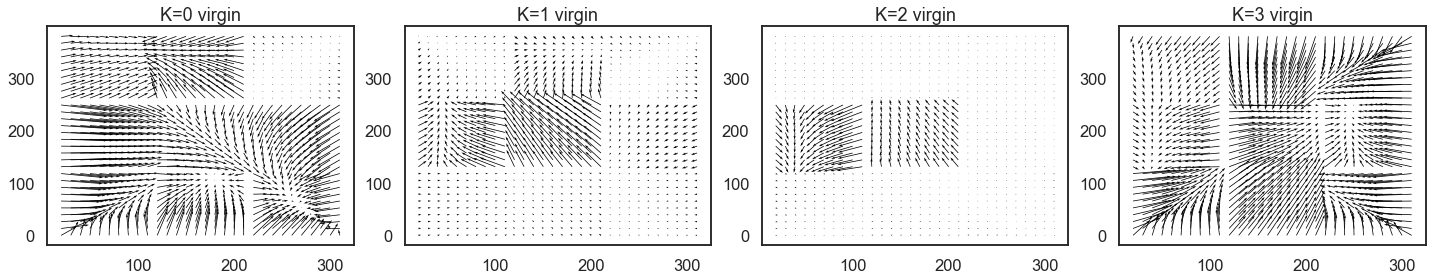

In [58]:
plot_quiver(XY_grids, dXY, 'virgin', scale=0.2)

In [59]:
[sum(z==k) for k in range(K)]

[4378, 9719, 21609, 294]

In [60]:
masks_z_a = np.array([(z[:-1] + 1) * masks_a[g].numpy() for g in range(G)])
masks_z_b = np.array([(z[:-1] + 1) * masks_b[g].numpy() for g in range(G)])

In [61]:
masks_z_a.shape

(9, 35999)

In [62]:
grid_z_a = np.array([[sum(masks_z_a[g] == k) for k in range(1,5)] for g in range(G)])
grid_z_b = np.array([[sum(masks_z_b[g] == k) for k in range(1,5)] for g in range(G)])

In [63]:
grid_z_a_percentage = grid_z_a / grid_z_a.sum(axis=1)[:,None]
grid_z_b_percentage = grid_z_b / grid_z_b.sum(axis=1)[:,None]

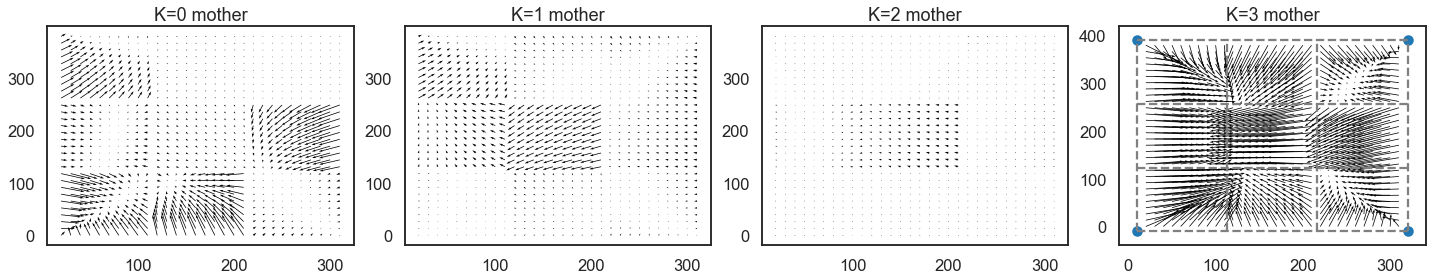

In [64]:
plot_quiver(XY_grids, dXY, 'mother', scale=0.2)
plot_grid()

In [70]:
speed = np.diff(trajs, axis=0)

In [69]:
result_corner_vecs_a = np.sum(weighted_corner_vecs_a, axis=2)

In [65]:
weighted_corner_vecs_b[3,0,1,]

array([-1.96864673,  4.23364888])

In [66]:
(CORNERS[1].numpy() - grid_centers[3]) / weighted_corner_vecs_b[3,0,1,]

array([78.7342887, 78.7342887])

In [67]:
np.average(abs(speed), axis=0)

array([0.76620635, 0.78358849, 1.16686396, 1.14097278])

In [68]:
model.transition.stationary_transition_matrix

tensor([[9.2035e-01, 2.7296e-02, 5.1484e-02, 8.6985e-04],
        [1.1834e-02, 8.3649e-01, 1.5144e-01, 2.3393e-04],
        [1.1299e-02, 7.0582e-02, 9.1787e-01, 2.5033e-04],
        [1.0314e-02, 1.3973e-02, 1.4518e-02, 9.6119e-01]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [22]:
trajs.shape

(36000, 4)

In [23]:
speed = np.diff(trajs, axis=0)

In [24]:
speed.shape

(35999, 4)

In [26]:
np.mean(abs(speed), axis=0)

array([0.76620635, 0.78358849, 1.16686396, 1.14097278])

In [27]:
np.std(abs(speed), axis=0)

array([0.97498271, 1.03915737, 1.57238873, 1.57277836])

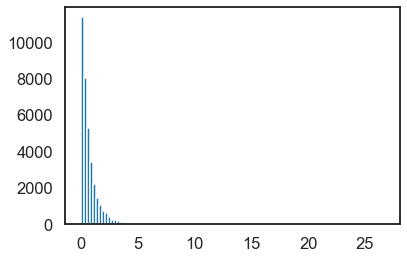

In [30]:
plt.hist(abs(speed[:,0]), bins=100);

In [72]:
joblib.dump(model, "model_k4")

['model_k4']

In [71]:
for p1, p2 in zip(model.params_unpack, model_r.params_unpack):
    assert torch.all(torch.eq(p1, p2))